# <center> Alternative Phase Noise Measurement System </center>
<center> Josh Wilkins <br> 07/06/2017 </center>

Unfortunately, sometimes all the instruments available to you have higher noise floors than the device you are trying to measure. This is why I created this alternative phase noise measurement device. This file outlines the device's construction and its use by example in the comparison of two comb generator technologies.

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
from scipy.signal import filtfilt as filt
import pandas as pd

import sys
sys.path.append('../_Modules/')
from labInstrument import csvData
from interpolate import interpolate

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:
# Custom Functions

def getNoise(noiseFile):
    data = csvData(noiseFile).getData()
    time = data[:,0]
    noise = data[:,1]

    noise = noise - noise.mean()  # Remove any offset
    time = time - time[0]  # Shift to make times positive

    return time, noise

def convertNoise(noiseFile, scale):  # Scale is in °/V
    time, noise = getNoise(noiseFile)

    # Number of sample points
    N = len(noise)-1
    
    # Sample spacing (Sampling Rate)
    T = time[-1]/N

    # Converting Noise (From V to Rad)
    radNoise = noise * scale * np.pi / 180

    # Fourier Transform of Noise
    avg = int(np.round(N*T))     # Can be any integer 2 ≤ avg ≤ N*T
    npts = int(np.round(avg/T))  # Number of fft points such that BW = 1Hz/avg
    
    if (npts <= N):
        freqNoise = fft(radNoise, npts)/npts
        rmsPhaseNoise = np.sqrt( (np.convolve(freqNoise*np.conj(freqNoise), np.ones(avg), mode='same')) )
        xf = np.linspace(0.0, 1.0/T, npts)
        yf = 20.0*np.log10(np.abs(rmsPhaseNoise))
        return xf, yf
    else:
        print 'Not enough points - Use smaller avg factor'

## <center> Details </center>

This alternative phase noise measurement device requires some additional hardware. A power splitter, mixer, low pass filter, and a DC amplifier. One of the downsides of this approach, besides the use of additional hardware, is that it requires two of the same device being measured as shown in the figure below.

<img src="./Images/Setup.png" />

It is good to have a low frequency LPF and an amplifier at the output of the mixer to maximize resolution and ensure the noise floor of the instrument is lower than the device's phase noise.

Another downside of this device is that the two devices being measured must be at identical frequencies. Either splitting the reference as shown above or by locking the frequency of one device to the other works. If this is not done, a 'beat-note' remains at the output of the mixer causing what I am calling independent source 'drift' error. The following figures can give you an idea of its affect on the predicted phase noise output and is best to be avoided if possible.

156.74%


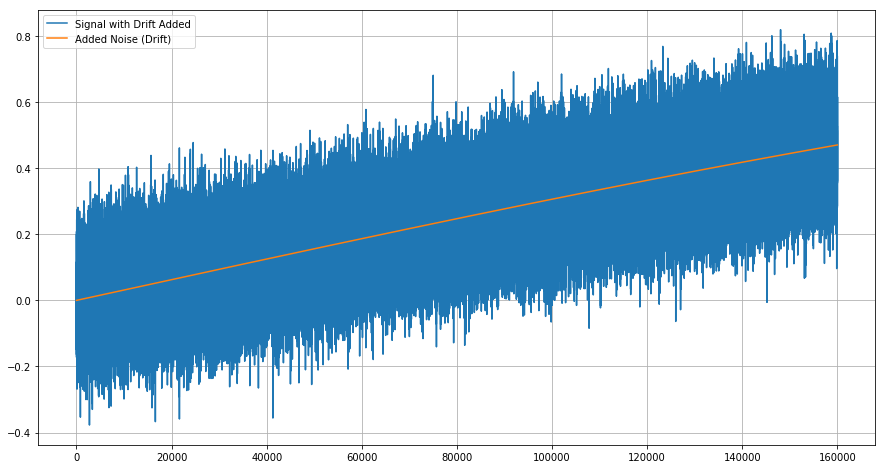

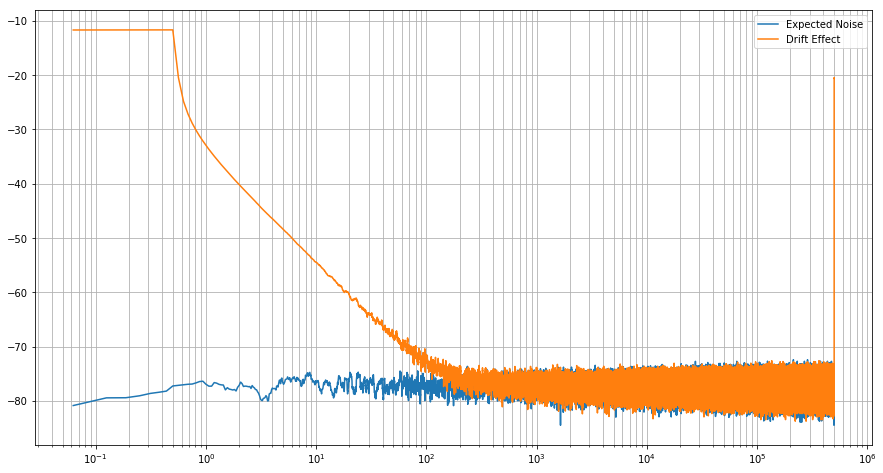

In [4]:
# Affect of the Frequency Difference Between two Sources ('Drift')

npts = int(8e6)
drift = 0.8*np.sin(2*np.pi*0.1*np.arange(npts)/npts)
noise1 = 0.1*np.random.randn(npts) # -77dB
noise2 = 0.1*np.random.randn(npts) + drift  # -77dB

difference = (drift[-1] / 0.3) * 100
print '%0.2f%%' % difference

plt.plot(noise2[::50], label='Signal with Drift Added')
plt.plot(drift[::50], label='Added Noise (Drift)')
plt.grid(which='both')
plt.legend()
plt.figure()

T = 2e-6
freqNoise1 = fft(noise1, npts)/npts
freqNoise2 = fft(noise2, npts)/npts
rmsPhaseNoise1 = np.sqrt( (np.convolve(freqNoise1*np.conj(freqNoise1), np.ones(16), mode='same')) )
rmsPhaseNoise2 = np.sqrt( (np.convolve(freqNoise2*np.conj(freqNoise2), np.ones(16), mode='same')) )
xf = np.linspace(0.0, 1.0/T, npts)
yf1 = 20.0*np.log10(np.abs(rmsPhaseNoise1))
yf2 = 20.0*np.log10(np.abs(rmsPhaseNoise2))

plt.semilogx(xf, yf1, label='Expected Noise')
plt.semilogx(xf, yf2, label='Drift Effect')
plt.grid(which='both')
plt.legend()

The results of this test indicate that any measurements made with two independent source will not be accurate for measuring the close-in phase noise. To work around this, a digital PI filter with a very low bandwidth is being created to tie two sources together and remove this drift effect.

## <center> Comb Generator Comparison </center>

The two comb generator technologies that will be compared are the standard step-recovery diode technique as in the Herotek GC100RC generator and the Non-linear transmission line (NLTL) technology as seen in the Macom MLPNC-7100.

In [5]:
# Collect Comb Generator Data

xfHerotek, yfHerotek = convertNoise('Herotek_GC100RC.csv', 246) # Step Recovery Diode Technology
xfMaCom, yfMaCom = convertNoise('MaCom_MLPNC7100.csv', 154) # Non-Linear Transmission Line Technology

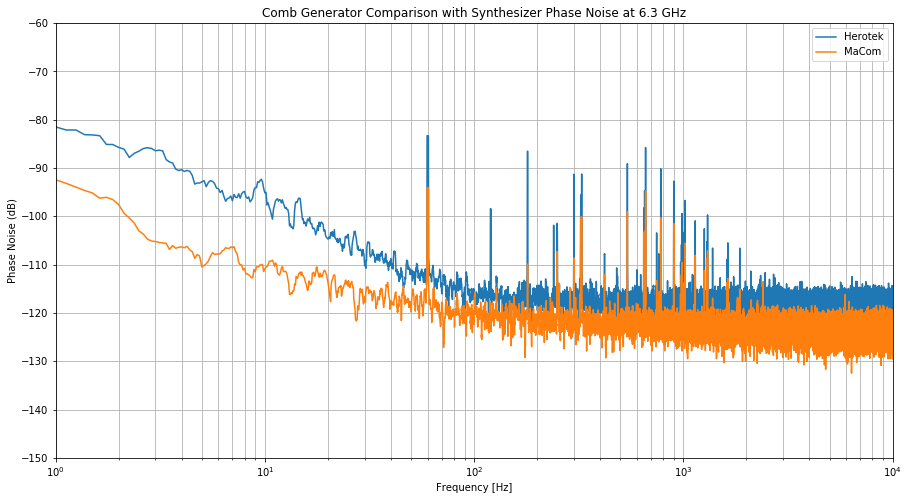

In [7]:
# Comb Gen Comparison with

plt.semilogx(xfHerotek, yfHerotek-60, label = 'Herotek')  # -60dB for Amp Gain
plt.semilogx(xfMaCom, yfMaCom-60, label = 'MaCom')

plt.title('Comb Generator Comparison with Synthesizer Phase Noise at 6.3 GHz')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase Noise (dB)')
plt.xlim(1,1e4)
plt.ylim(-150, -60)
plt.grid(which='both')
plt.legend()
plt.show()

The noise floor of the new setup should also be measured by splitting any source (as shown below) and repeating this test. It was not necessary in this case because the Herotek comb generator was sufficient for our design, but should generally be done.

<img src="./Images/MixerNoise.png" />